In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys
import os

# modify the path below accordingly
PATH = "/content/drive/MyDrive/compvision/gesture_face_features"

sys.path.append(os.path.join(PATH, "code"))

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# pip install mediapipe

In [5]:
# importing .py files from /code
from utils import *
from cam import *
from tsne import TSNECluster
# from hand_extraction import *

In [139]:
import os
import re
import pickle

import numpy as np
# import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
import requests

from PIL import Image
from io import BytesIO

import umap.umap_ as umap
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

In [7]:
from tensorflow.keras.models import Model

In [8]:
# Main configurations

available_letters = ["A", "H", "L", "N", "O", "P", "R"]

participants = {
  0: list(range(2914, 2951)),
  1: list(range(2871, 2904)),
  2: list(range(2323, 2356)),
  3: list(range(2285, 2314)),
  4: list(range(1646, 1675)),
  5: list(range(1510 , 1544)),
}

test_imgs = [2919, 2871, 2325, 2287, 1646, 1539]

available_models = [
  "VGG19",
  "ResNet50",
  "InceptionV3",
  "EfficientNetB0",
  "EfficientNetB1",
  "EfficientNetB6",
  #"EfficientNetB7",
]

In [60]:
# Secondary configurations
letter = available_letters[:]
img_type = 'sign'
img_count = None
partic_num = 5
participant = participants[partic_num]

# Model configurations
model_name = available_models[2]
input_dim = (224, 224) # default
model = None
include_top = True
debug = False

In [61]:
model_configs = {
  'resnet50': {
    'last_conv_layer_name': 'conv5_block3_out',
    'fc_gap_layer_name': 'avg_pool',
    'input_dim': (224, 224),
  },
  'vgg19': {
    'last_conv_layer_name': 'block5_conv4',
    'fc_gap_layer_name': 'fc2',
    'input_dim': (224, 224),
  },
  'inception_v3': {
    'last_conv_layer_name': 'mixed10',
    'fc_gap_layer_name': 'avg_pool',
    'input_dim': (299, 299),
  },
  'efficientnetb0': {
    'last_conv_layer_name': 'top_conv',
    'fc_gap_layer_name': 'avg_pool',
    'input_dim': (224, 224),
  },
  'efficientnetb1': {
    'last_conv_layer_name': 'top_conv',
    'fc_gap_layer_name': 'avg_pool',
    'input_dim': (240, 240)
  },
  'efficientnetb6': {
    'last_conv_layer_name': 'top_conv',
    'fc_gap_layer_name': 'avg_pool',
    'input_dim': (528, 528),
  },
  'efficientnetb7': {
    'last_conv_layer_name': 'top_conv',
    'fc_gap_layer_name': 'avg_pool',
    'input_dim': (600, 600),
  }
}

In [62]:
def load_model(model_name, include_top=True, debug=False):
  if model_name == 'ResNet50':
    from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
    model = ResNet50(include_top=include_top)
    configs = model_configs['resnet50']
  elif model_name == 'VGG19':
    from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input, decode_predictions
    model = VGG19(include_top=include_top)
    configs = model_configs['vgg19']
  elif model_name == 'InceptionV3':
    from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions
    model = InceptionV3(include_top=include_top)
    configs = model_configs['inception_v3']
  elif model_name == 'EfficientNetB0':
    from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input, decode_predictions
    model = EfficientNetB0(include_top=include_top)
    configs = model_configs['efficientnetb0']
  elif model_name == 'EfficientNetB1':
    from tensorflow.keras.applications.efficientnet import EfficientNetB1, preprocess_input, decode_predictions
    model = EfficientNetB1(include_top=include_top)
    configs = model_configs['efficientnetb1']
  elif model_name == 'EfficientNetB6':
    from tensorflow.keras.applications.efficientnet import EfficientNetB6, preprocess_input, decode_predictions
    model = EfficientNetB6(include_top=include_top)
    configs = model_configs['efficientnetb6']
  elif model_name == 'EfficientNetB7':
    from tensorflow.keras.applications.efficientnet import EfficientNetB7, preprocess_input, decode_predictions
    model = EfficientNetB7(include_top=include_top)
    configs = model_configs['efficientnetb7']
  else:
    raise ValueError("Unsupported model name.")

  if debug:
    print(model.summary())

  print(f"{model.name} loaded")

  layer_names = (configs['last_conv_layer_name'], configs['fc_gap_layer_name'])
  input_dim = configs['input_dim']

  output = (
    model,
    layer_names,
    input_dim,
    preprocess_input,
    decode_predictions,
  )

  return output

In [63]:
model, layer_names, input_dim, preprocess_input, decode_predictions = load_model(model_name)

inception_v3 loaded


In [64]:
# Loading data
folder_paths, img_paths, labels, img_numbers = get_paths(os.path.join(PATH, 'samples', img_type), letter, img_count=img_count, img_numbers_list=participant)
imgs = load_imgs(img_paths)

33 images loaded


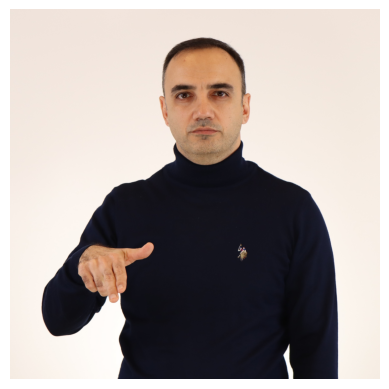

In [65]:
# Testing
img = imgs[9]
plt.imshow(img)
plt.axis('off')
plt.show()

In [66]:
def get_features(img, model, input_dim, layer_names):
    feature_model = Model(inputs=model.input, outputs=[model.get_layer(name).output for name in layer_names])

    img_resized = img.resize(input_dim)
    img_array = np.array(img_resized)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    return feature_model.predict(img_array)

In [67]:
def get_layer_feats(model, imgs, layer_names, input_dim, partic_num, path=os.path.join(PATH, 'pickle')):
    """
    Extracts and saves features from specified layers of a model for each image in imgs.
    If a feature file for a layer already exists, it loads that layer's features directly.
    For missing layers, it performs a forward pass to compute and save those features.

    Parameters:
    - model: The model from which to extract features.
    - partic_num: Identifier for the participant (used in filenames).
    - imgs: List of images to process.
    - layer_names: List of layer names for feature extraction.
    - input_dim: Input dimensions for the model.
    - path: Base path to save or load pickle files.

    Returns:
    - all_feats: Dictionary of features, with each layer's features stored as a numpy array.
    """
    all_feats = {}
    layers_to_compute = []

    for layer in layer_names:
      feats_file = f"{model.name}_{layer}_participant_{partic_num}.pkl"
      feats_path = os.path.join(path, feats_file)

      if os.path.exists(feats_path):
        with open(feats_path, 'rb') as f:
            all_feats[layer] = pickle.load(f)
        print(f"Loaded existing features for layer '{layer}' from {feats_path}")
      else:
        layers_to_compute.append(layer)
        all_feats[layer] = []

    if layers_to_compute:
      print(f"Performing forward pass for layer(s): {layers_to_compute}")
      for i, img in enumerate(imgs):
        feature_activations = get_features(img, model, input_dim, layers_to_compute)

        for layer, feat in zip(layers_to_compute, feature_activations):
            all_feats[layer].append(feat.flatten())
        print(f"Processed image {i}.")

      for layer in layers_to_compute:
        all_feats[layer] = np.array(all_feats[layer])

        feats_file = f"{model.name}_{layer}_participant_{partic_num}.pkl"
        feats_path = os.path.join(path, feats_file)

        with open(feats_path, 'wb') as f:
            pickle.dump(all_feats[layer], f)
        print(f"Features for layer '{layer}' saved to {feats_path}")

    return all_feats

In [68]:
# model, layer_names, input_dim, preprocess_input, decode_predictions = load_model("ResNet50", include_top, debug)
all_feats = get_layer_feats(model, imgs, layer_names, input_dim, partic_num)

Loaded existing features for layer 'mixed10' from /content/drive/MyDrive/compvision/gesture_face_features/pickle/inception_v3_mixed10_participant_5.pkl
Loaded existing features for layer 'avg_pool' from /content/drive/MyDrive/compvision/gesture_face_features/pickle/inception_v3_avg_pool_participant_5.pkl


# UMAP

In [69]:
# model, layer_names, input_dim, preprocess_input, decode_predictions = load_model("EfficientNetB0", include_top, debug)
# model.name

In [70]:
pip install umap-learn

In [118]:
def load_partic_feats(partic_num, path=os.path.join(PATH, 'pickle')):
  partic_feats = {}

  for file in os.listdir(path):
    if f"participant_{partic_num}" in file:
      for model_name in model_configs.keys():
        if model_name in file:
            feats_path = os.path.join(path, file)
            try:
              with open(feats_path, 'rb') as f:
                loaded_feats = pickle.load(f)

                if model_name not in partic_feats:
                    partic_feats[model_name] = {}

                layer_names = list(model_configs[model_name].values())[:2]
                for layer_name in layer_names:
                  if layer_name in file:
                    partic_feats[model_name][layer_name] = loaded_feats
                    print(f"Loaded {layer_name} features for {model_name}")
            except FileNotFoundError:
                print(f"File not found: {feats_path}")

  return partic_feats

In [122]:
def get_embeddings(partic_feats):
    embeddings = {}
    reducer = umap.UMAP(n_neighbors=5, min_dist=0.1, n_components=2, metric="euclidean")

    for model_name in partic_feats:
        embeddings[model_name] = {}
        for layer_name in partic_feats[model_name]:
            embedding = reducer.fit_transform(partic_feats[model_name][layer_name])
            embeddings[model_name][layer_name] = embedding
            print(f"Computed embeddings for {model_name} layer {layer_name}")

    return embeddings

In [132]:
partic_feats = load_partic_feats(5)
embeddings = get_embeddings(partic_feats)

Loaded top_conv features for efficientnetb0
Loaded mixed10 features for inception_v3
Loaded avg_pool features for efficientnetb0
Loaded block5_conv4 features for vgg19
Loaded fc2 features for vgg19
Loaded conv5_block3_out features for resnet50
Loaded avg_pool features for resnet50
Loaded avg_pool features for inception_v3
Computed embeddings for efficientnetb0 layer top_conv
Computed embeddings for efficientnetb0 layer avg_pool
Computed embeddings for inception_v3 layer mixed10
Computed embeddings for inception_v3 layer avg_pool
Computed embeddings for vgg19 layer block5_conv4
Computed embeddings for vgg19 layer fc2
Computed embeddings for resnet50 layer conv5_block3_out
Computed embeddings for resnet50 layer avg_pool


In [142]:
n_clusters = len(set(labels))
all_clusters = {}

for model_name in embeddings:
  all_clusters[model_name] = {}
  for layer_name, embedding in embeddings[model_name].items():
    kmeans = KMeans(n_clusters=n_clusters)
    cluster_labels = kmeans.fit_predict(embedding)
    all_clusters[model_name][layer_name] = cluster_labels
    print(f"Calculated Kmeans clusters for {model_name} {layer_name}")

Calculated Kmeans clusters for efficientnetb0 top_conv
Calculated Kmeans clusters for efficientnetb0 avg_pool
Calculated Kmeans clusters for inception_v3 mixed10
Calculated Kmeans clusters for inception_v3 avg_pool
Calculated Kmeans clusters for vgg19 block5_conv4
Calculated Kmeans clusters for vgg19 fc2
Calculated Kmeans clusters for resnet50 conv5_block3_out
Calculated Kmeans clusters for resnet50 avg_pool


In [152]:
clustered_images = {}

for model_name in all_clusters:
  clustered_images[model_name] = {}

  for layer_name, cluster_labels in all_clusters[model_name].items():
    clusters = {i: [] for i in range(n_clusters)}

    for img_num, cluster, label in zip(img_numbers, cluster_labels, labels):
      clusters[cluster].append((img_num, label))

    clustered_images[model_name][layer_name] = clusters
    print(f"Clusters for {model_name} {layer_name}:")

    for cluster, img_list in clusters.items():
      print(f"{cluster}: {img_list}")
    print()

Clusters for efficientnetb0 top_conv:
0: [(1540, 'A'), (1542, 'A'), (1541, 'A'), (1543, 'A')]
1: [(1538, 'H'), (1528, 'P'), (1527, 'P'), (1530, 'P'), (1532, 'P'), (1531, 'P'), (1526, 'L')]
2: [(1521, 'N'), (1514, 'R'), (1512, 'R'), (1513, 'R'), (1515, 'R')]
3: [(1529, 'P'), (1522, 'L'), (1523, 'L'), (1524, 'L'), (1525, 'L')]
4: [(1539, 'A'), (1533, 'H'), (1537, 'H'), (1534, 'H'), (1535, 'H')]
5: [(1517, 'N'), (1519, 'N'), (1518, 'N'), (1520, 'N'), (1511, 'R'), (1510, 'R'), (1516, 'R')]

Clusters for efficientnetb0 avg_pool:
0: [(1540, 'A'), (1539, 'A'), (1542, 'A'), (1541, 'A'), (1543, 'A')]
1: [(1514, 'R'), (1512, 'R'), (1511, 'R'), (1510, 'R'), (1516, 'R'), (1515, 'R')]
2: [(1538, 'H'), (1528, 'P'), (1527, 'P'), (1529, 'P'), (1530, 'P'), (1532, 'P'), (1531, 'P'), (1522, 'L'), (1526, 'L'), (1525, 'L')]
3: [(1533, 'H'), (1534, 'H'), (1523, 'L')]
4: [(1517, 'N'), (1519, 'N'), (1518, 'N'), (1521, 'N'), (1520, 'N'), (1513, 'R')]
5: [(1537, 'H'), (1535, 'H'), (1524, 'L')]

Clusters for inc

In [193]:
# Example usage of the function
plot_image_clusters(clustered_images, "resnet50", "conv5_block3_out")

In [157]:
# Define similarity scores
similarity_scores = {
    ('R', 'N'): 0.8,
    ('R', 'O'): 0.6,
    ('N', 'O'): 0.6,
    ('H', 'P'): 0.8,
    ('P', 'L'): 0.8,
    ('H', 'L'): 0.6,
}

# Add maximal similarity for identical letters
for letter in 'AHLNPRO':
    similarity_scores[(letter, letter)] = 1.0  # Identical letters get maximal score

def get_similarity_score(letter1, letter2):
    # Ensure pairs are checked consistently regardless of order
    return similarity_scores.get((letter1, letter2)) or similarity_scores.get((letter2, letter1), 0)

# Initialize the layer scores dictionary
layer_scores = {}

# Calculate scores for each layer based on clustering similarity
for model_name, layers in clustered_images.items():
    layer_scores[model_name] = {}

    for layer_name, clusters in layers.items():
        total_layer_score = 0
        total_pairs = 0

        for cluster_id, images in clusters.items():
            letters = [label for _, label in images]  # Extract the letters in this cluster
            cluster_score = 0
            num_pairs = 0

            # Calculate similarity score for each unique pair in the cluster
            for i in range(len(letters)):
                for j in range(i + 1, len(letters)):
                    letter1, letter2 = letters[i], letters[j]
                    cluster_score += get_similarity_score(letter1, letter2)
                    num_pairs += 1

            # Normalize the cluster score by the number of pairs
            cluster_score = cluster_score / num_pairs if num_pairs > 0 else 0
            total_layer_score += cluster_score
            total_pairs += 1

            # print(f"Score for {model_name} layer {layer_name}, cluster {cluster_id}: {cluster_score:.2f}")

        # Calculate the average score for each layer
        average_layer_score = total_layer_score / total_pairs if total_pairs > 0 else 0
        layer_scores[model_name][layer_name] = average_layer_score
        print(f"Average score for {model_name} layer {layer_name}: {average_layer_score:.2f}")


Average score for efficientnetb0 layer top_conv: 0.87
Average score for efficientnetb0 layer avg_pool: 0.88
Average score for inception_v3 layer mixed10: 0.79
Average score for inception_v3 layer avg_pool: 0.71
Average score for vgg19 layer block5_conv4: 0.84
Average score for vgg19 layer fc2: 0.69
Average score for resnet50 layer conv5_block3_out: 0.91
Average score for resnet50 layer avg_pool: 0.86


In [160]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_embedding(embedding, labels, cluster_labels, img_numbers, n_clusters, model_name, layer_name):
    """Visualizes the embedding with a title of the model and layer name."""
    unique_labels = list(set(labels))
    markers = {'A': 'o', 'H': 's', 'L': 'D', 'N': '^', 'O': 'v', 'P': '<', 'R': '>'}
    colors = plt.cm.Spectral(np.linspace(0, 1, n_clusters))

    plt.figure(figsize=(12, 10))
    plt.title(f"Embedding Visualization for {model_name} - {layer_name}")

    for letter in unique_labels:
        indices = [i for i, l in enumerate(labels) if l == letter]
        cluster_color = colors[cluster_labels[indices[0]]]
        plt.scatter(embedding[indices, 0], embedding[indices, 1],
                    color=cluster_color,
                    marker=markers.get(letter, 'o'),
                    label=letter,
                    s=80, alpha=1)

        for i in indices:
            plt.text(embedding[i, 0], embedding[i, 1], img_numbers[i], fontsize=8, ha='right', color="black")

    for cluster_idx in range(n_clusters):
        cluster_points = embedding[cluster_labels == cluster_idx]
        if cluster_points.size > 0:
            min_x, min_y = cluster_points.min(axis=0)
            max_x, max_y = cluster_points.max(axis=0)
            padding = 0.1
            plt.gca().add_patch(plt.Rectangle(
                (min_x - padding, min_y - padding),
                (max_x - min_x) + 2 * padding,
                (max_y - min_y) + 2 * padding,
                fill=False, edgecolor=colors[cluster_idx], linewidth=1.5, linestyle="--"
            ))

    plt.legend(title='Letters', loc='center left', bbox_to_anchor=(1.05, 0.5), fancybox=True, shadow=True, ncol=1)
    plt.grid(True, linestyle='--', alpha=1)
    plt.tight_layout(rect=[0, 0.05, 1, 1])  # Adjust layout to fit the legend
    plt.show()


In [161]:

def plot_embeddings(embeddings, all_clusters, labels, img_numbers, n_clusters, model_to_plot=None, layer_to_plot=None):
    """
    Plots embeddings for each model and layer.
    Optionally filter by specific model or layer.
    """
    for model_name in embeddings:
        if model_to_plot and model_name != model_to_plot:
            continue  # Skip if not the chosen model

        for layer_name, embedding in embeddings[model_name].items():
            if layer_to_plot and layer_name != layer_to_plot:
                continue  # Skip if not the chosen layer

            cluster_labels = all_clusters[model_name][layer_name]
            visualize_embedding(
                embedding=embedding,
                labels=labels,
                cluster_labels=cluster_labels,
                img_numbers=img_numbers,
                n_clusters=n_clusters,
                model_name=model_name,
                layer_name=layer_name
            )


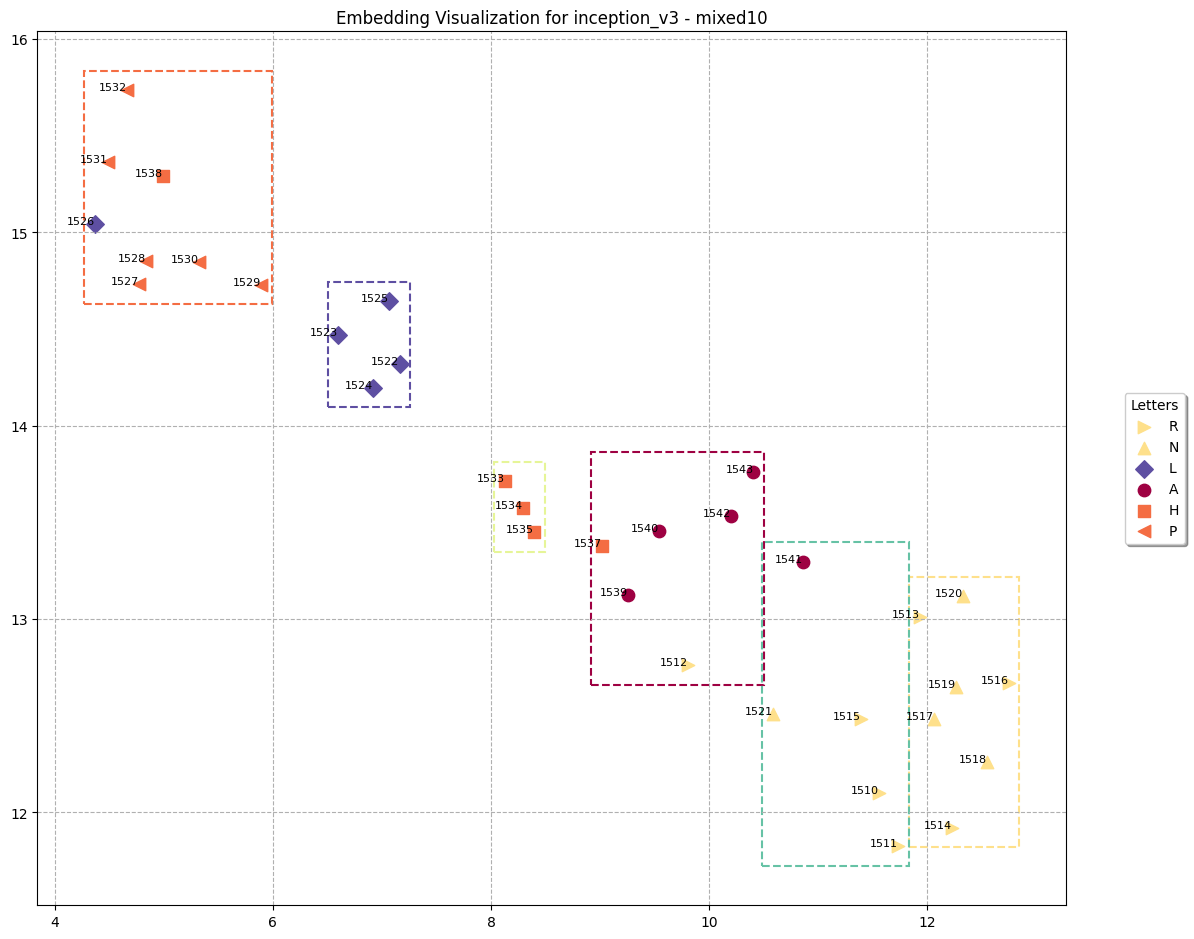

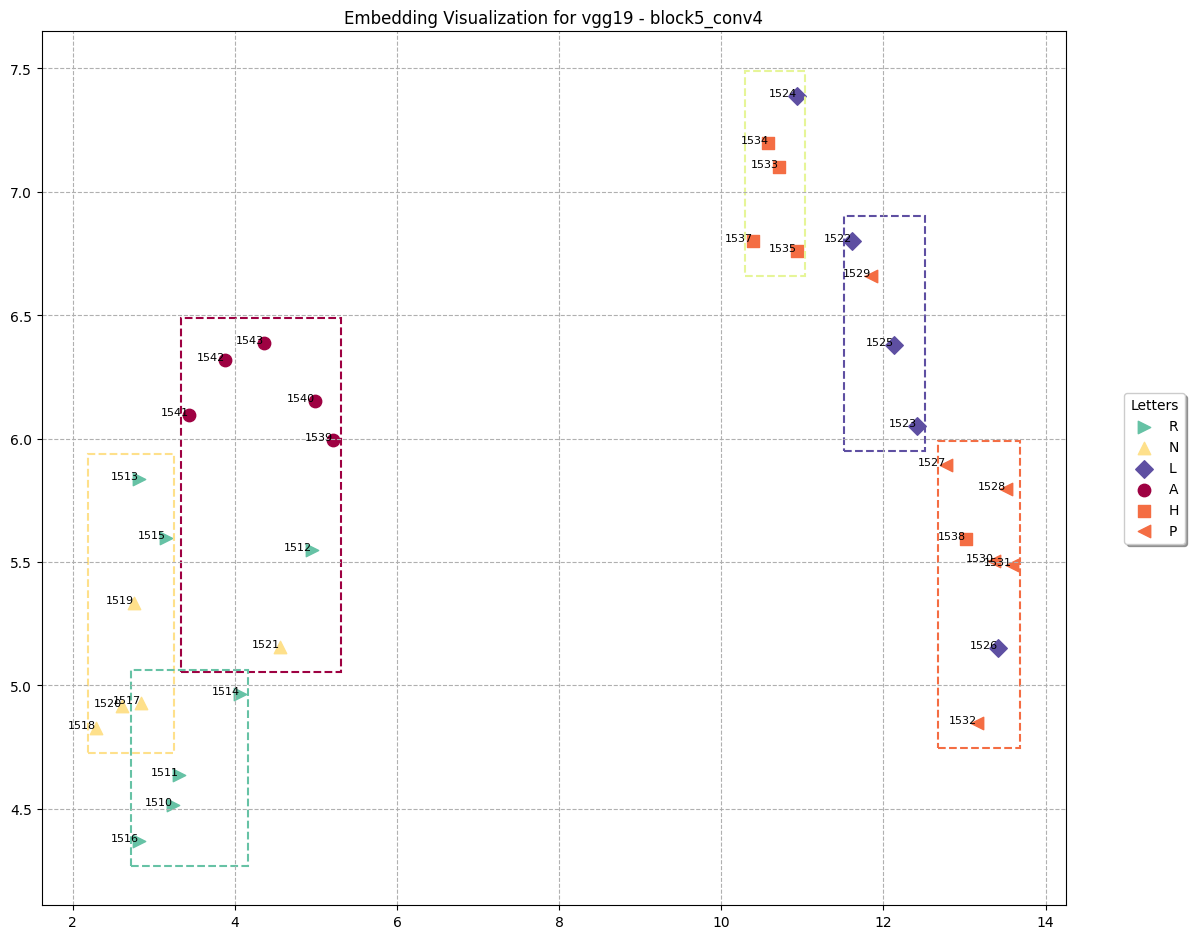

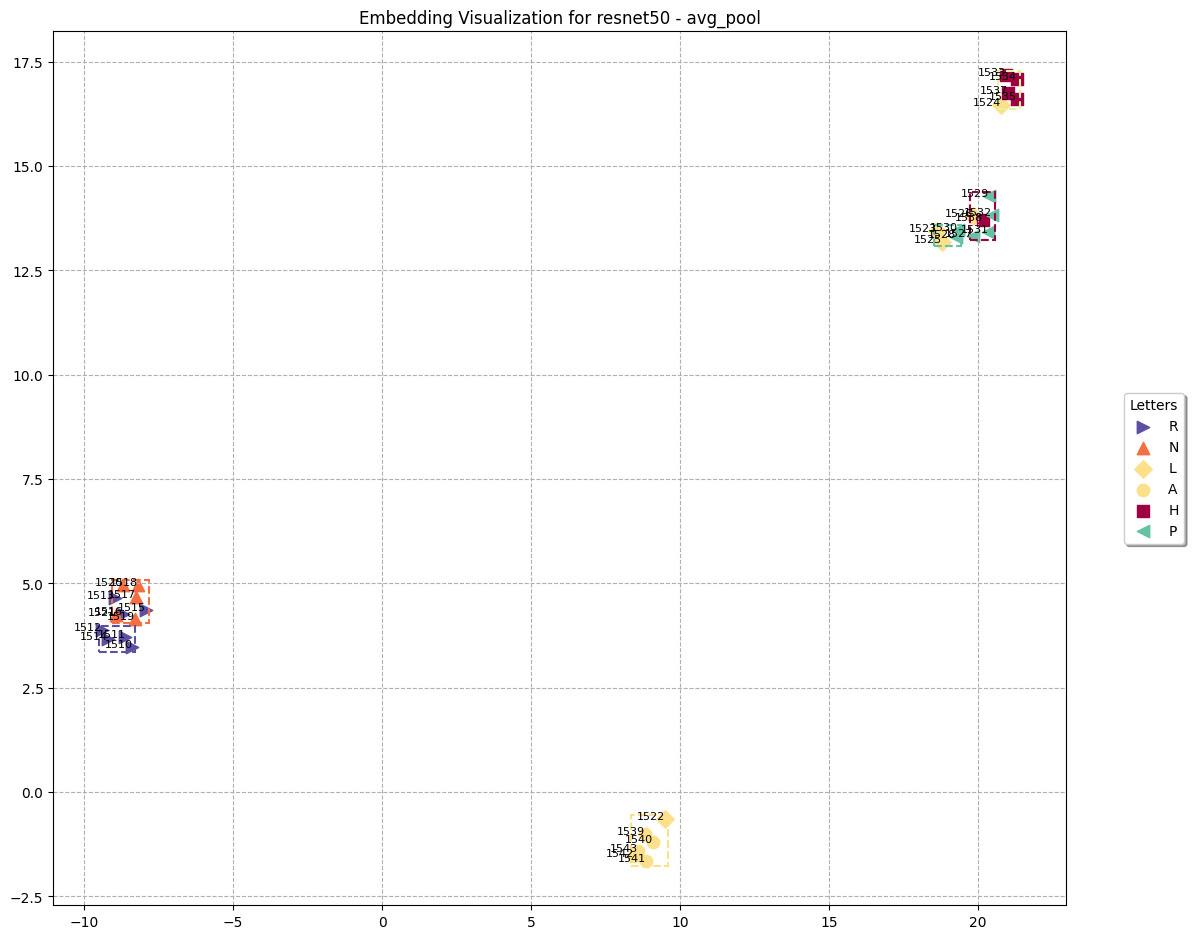

In [163]:
# Plot specific model and layer
plot_embeddings(embeddings, all_clusters, labels, img_numbers, n_clusters)

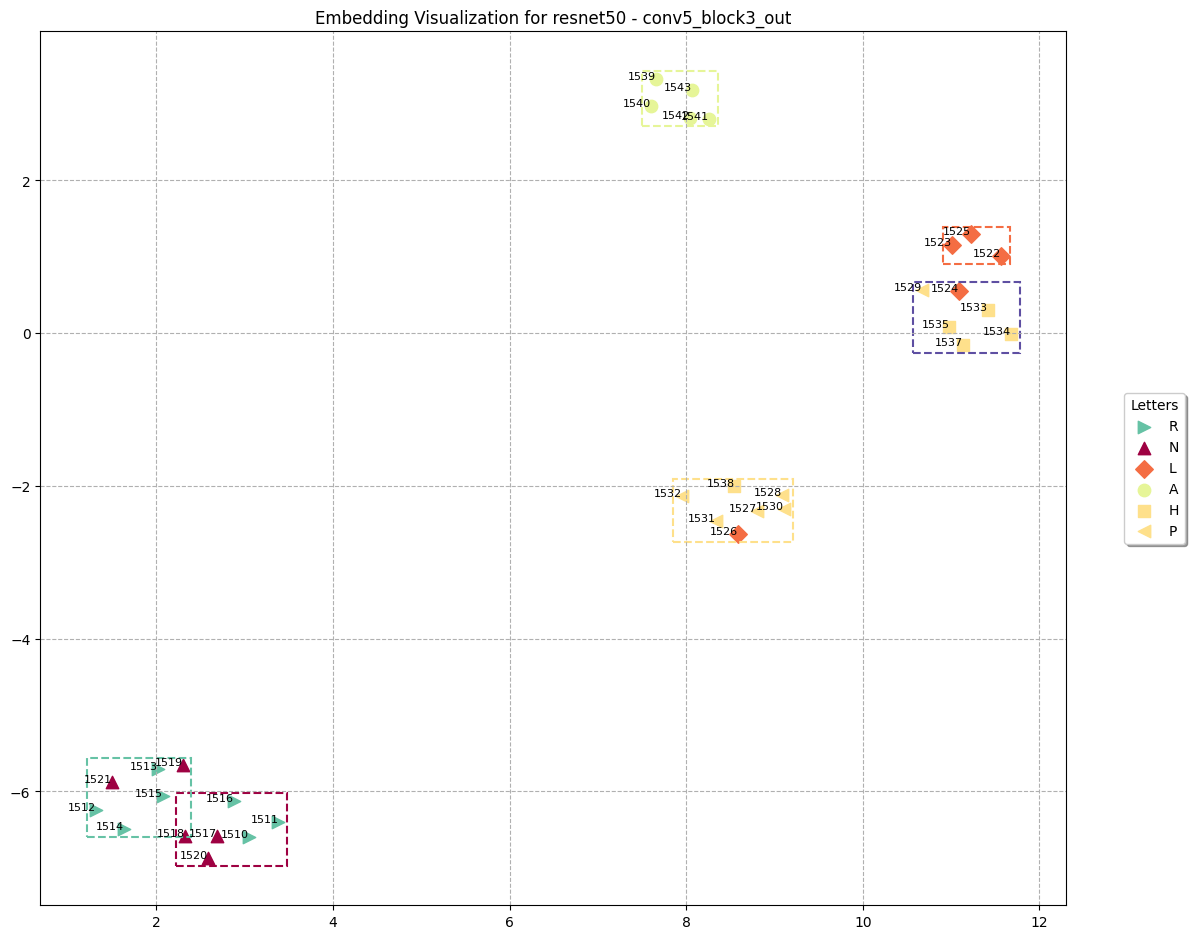

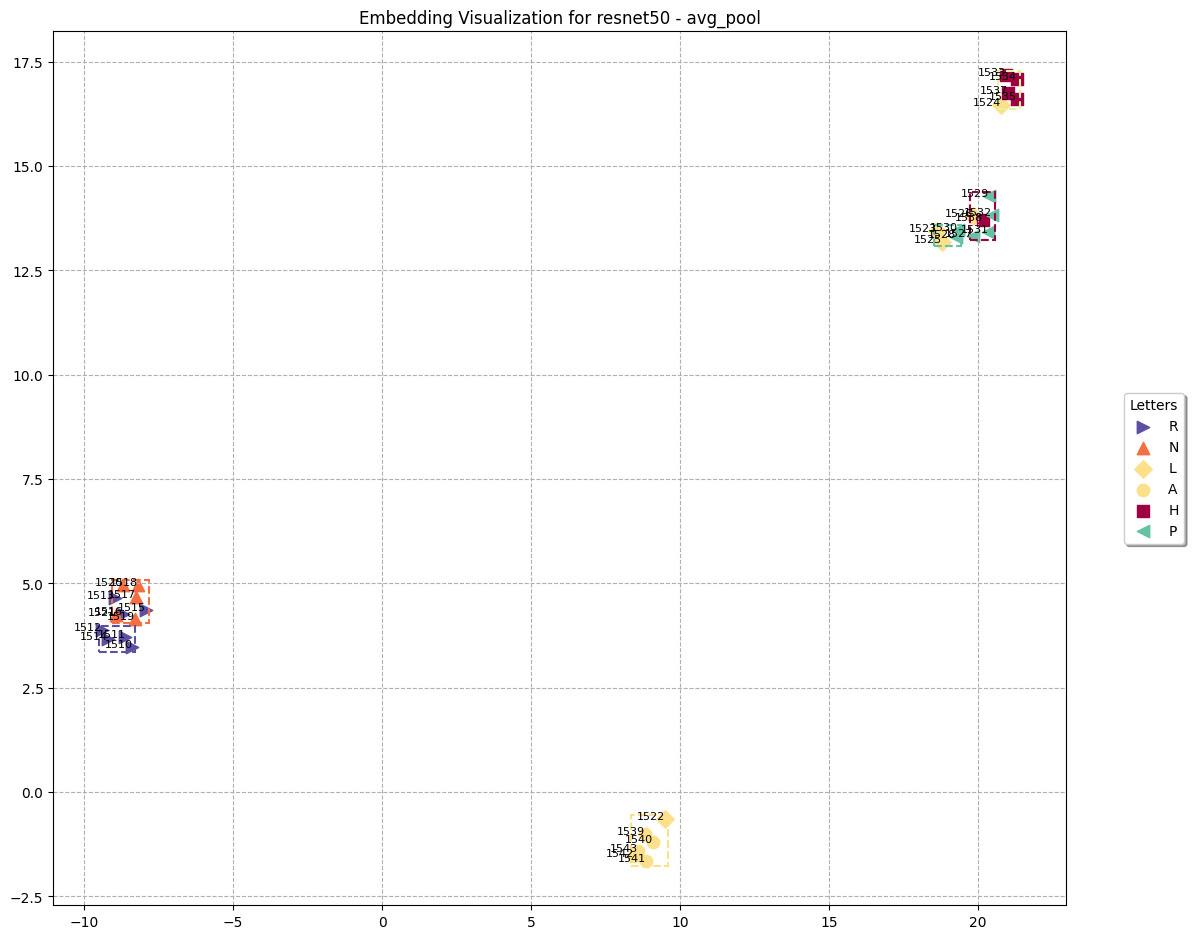

In [165]:
plot_embeddings(embeddings, all_clusters, labels, img_numbers, n_clusters, model_to_plot="resnet50")

In [192]:
import matplotlib.pyplot as plt

def plot_image_clusters(clustered_images, model_name, layer_name, target_size=(100, 100)):
    clusters = clustered_images.get(model_name, {}).get(layer_name, {})

    if not clusters:
        print(f"No clusters found for {model_name} {layer_name}.")
        return

    # Determine the maximum number of images in any cluster for consistent row widths
    max_images_per_row = max(len(img_list) for img_list in clusters.values())
    fig, axs = plt.subplots(len(clusters), max_images_per_row, figsize=(max_images_per_row * 3, len(clusters) * 3))

    for row_idx, (cluster, img_list) in enumerate(clusters.items()):
        for col_idx in range(max_images_per_row):
            if col_idx < len(img_list):
                img_num, label = img_list[col_idx]

                if img_num in img_numbers:
                    img_index = img_numbers.index(img_num)
                    img = imgs[img_index]  # Get the image from imgs list

                    # Resize the image
                    resized_img = img.resize(target_size)

                    # Plot the image
                    axs[row_idx, col_idx].imshow(resized_img)
                    axs[row_idx, col_idx].axis('off')  # Hide axes
                    axs[row_idx, col_idx].set_title(f'Letter: {label}')  # Optional title
                else:
                    print(f"Warning: img_num {img_num} is out of bounds for imgs list.")
                    axs[row_idx, col_idx].axis('off')  # Hide unused subplots
            else:
                axs[row_idx, col_idx].axis('off')  # Hide unused subplots

    # Adjust layout for the entire figure
    plt.tight_layout()
    plt.show()


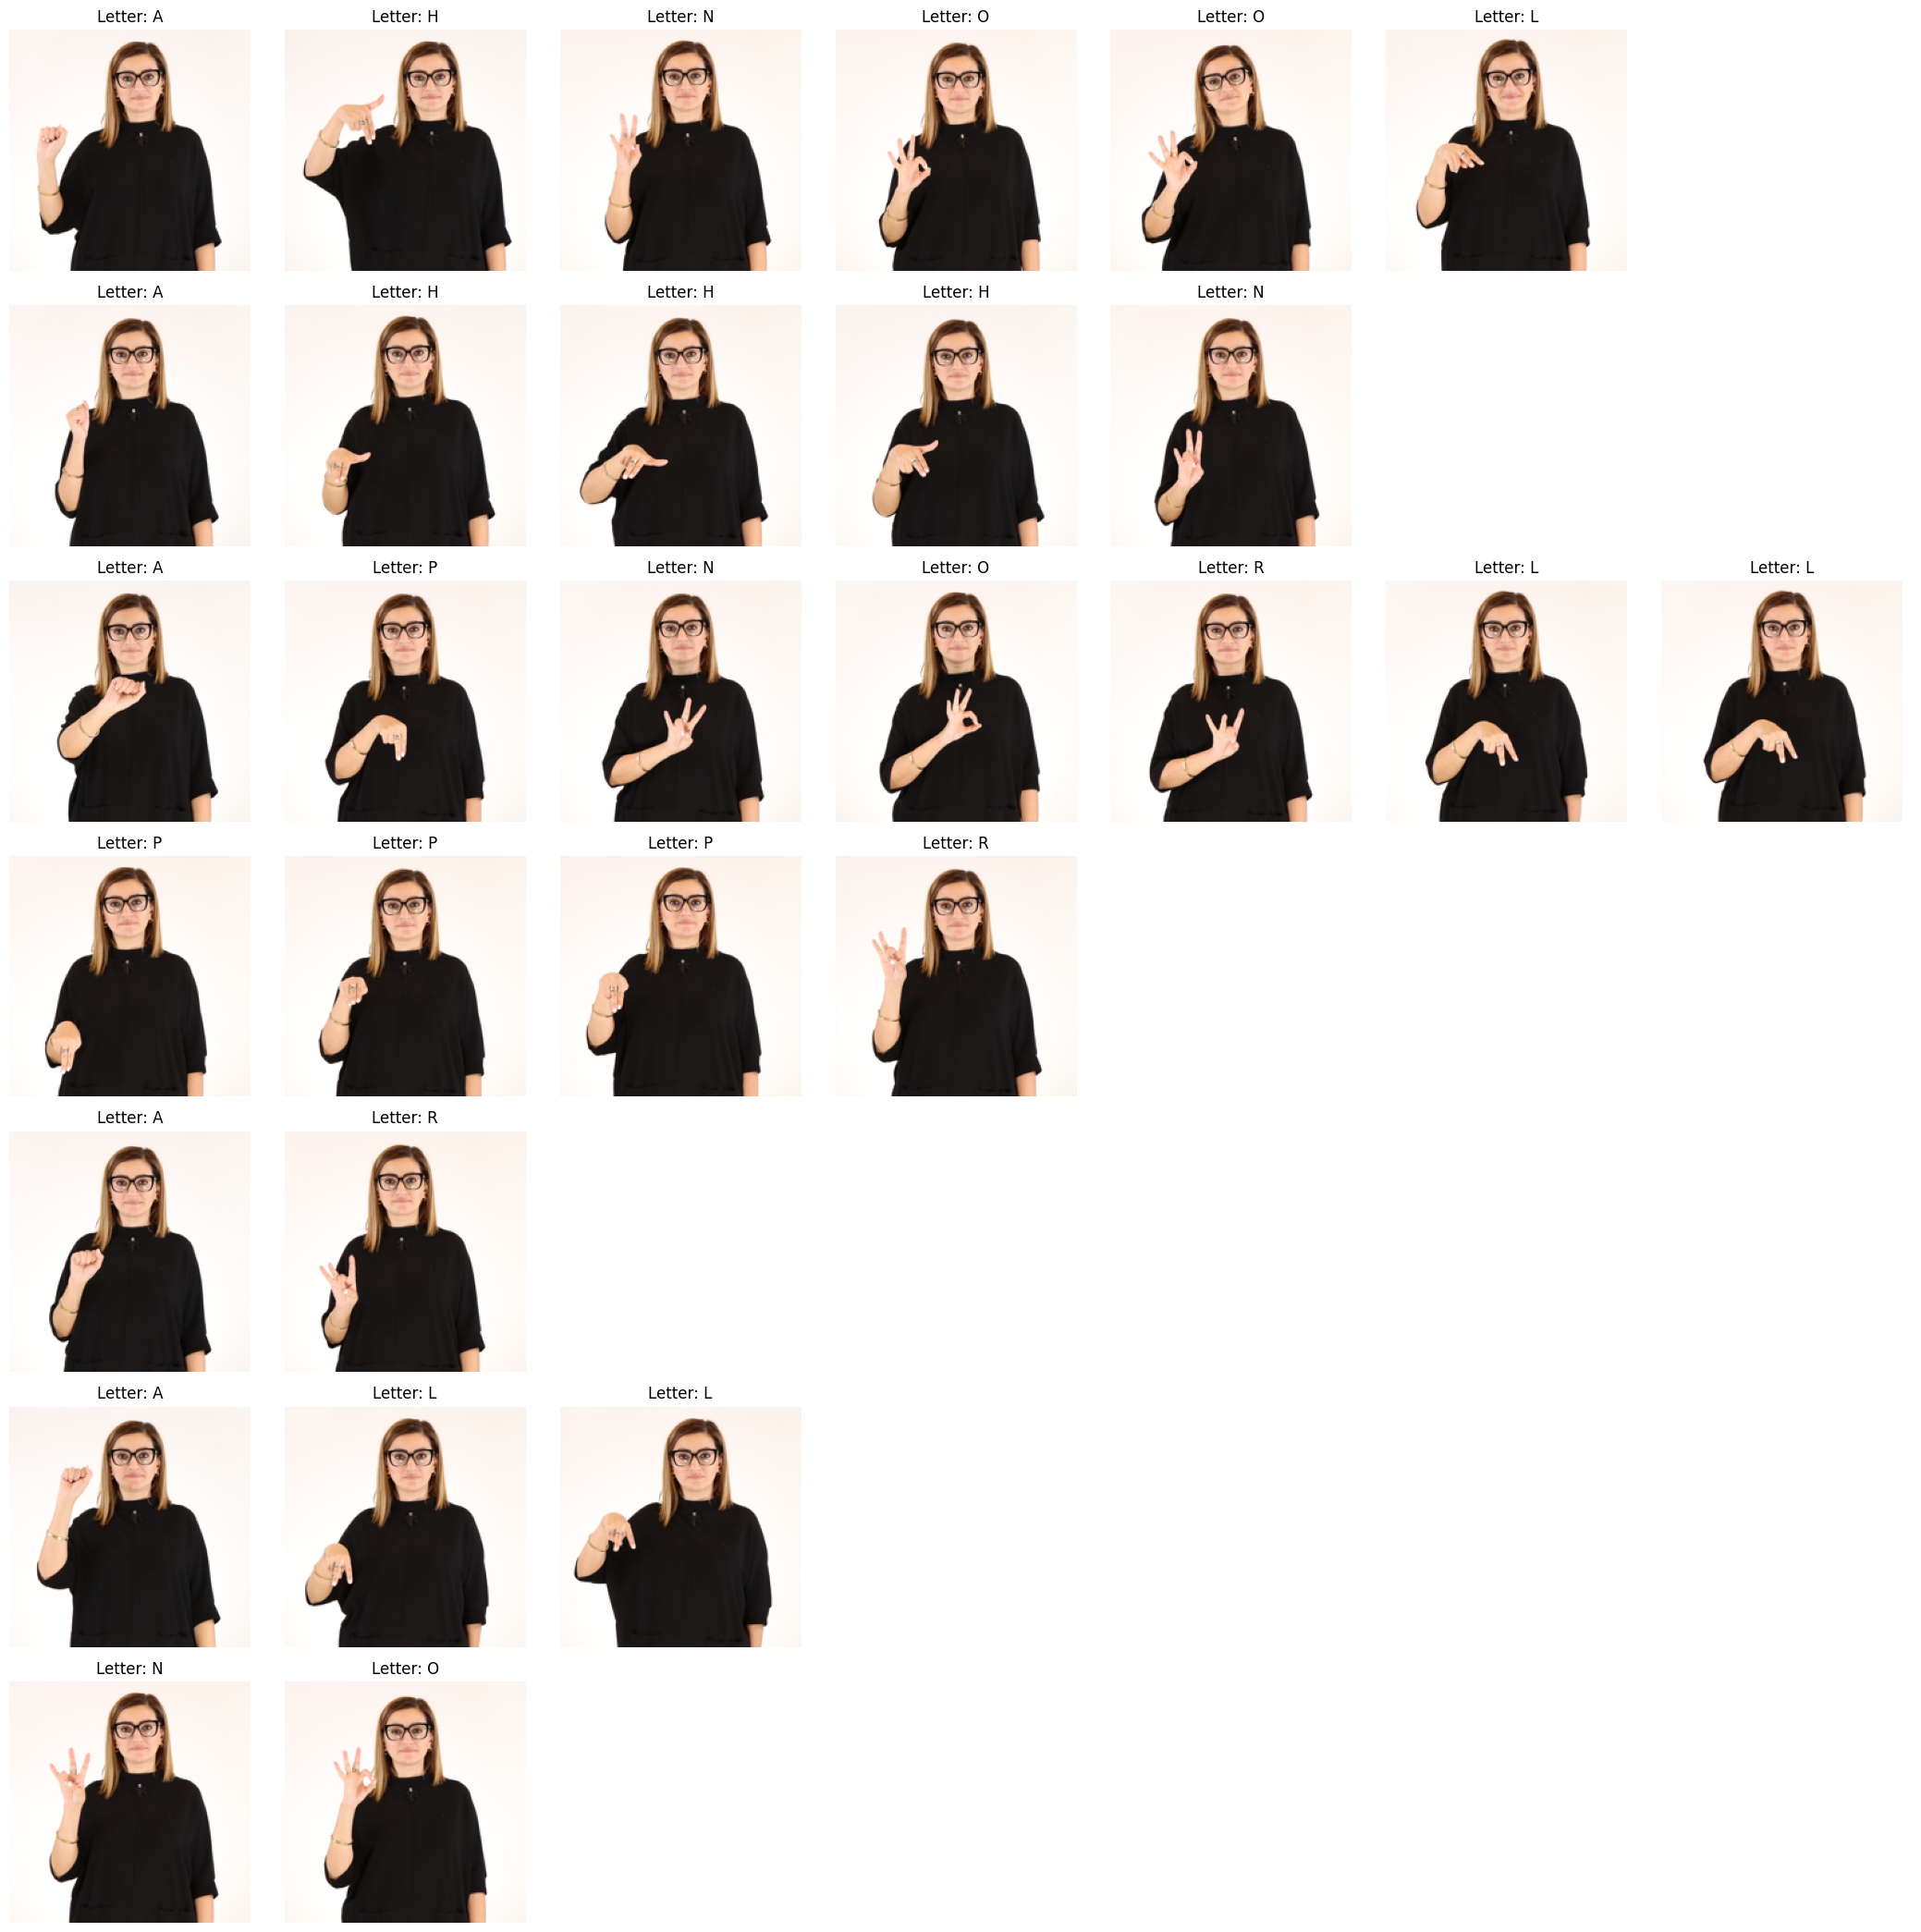

All clusters saved as 'all_clusters.png'. Cluster data saved to CSV.


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import os

# Set the target image size
target_size = (200, 200)

# Prepare a list to store cluster information for saving later
clustered_data = []

# Determine the maximum number of images in any cluster for consistent row widths
max_images_per_row = max(len(img_list) for img_list in clustered_images.values())

# Create a new figure for all clusters
fig, axs = plt.subplots(len(clustered_images), max_images_per_row, figsize=(max_images_per_row * 3, len(clustered_images) * 3))

# Loop through clusters and plot images
for row_idx, (cluster, img_list) in enumerate(clustered_images.items()):
    for col_idx in range(max_images_per_row):
        if col_idx < len(img_list):
            img_num, label = img_list[col_idx]
            # Find the index of the image in imgs corresponding to img_num
            img_index = img_numbers.index(img_num)
            img = imgs[img_index]  # Get the image from imgs list

            # Resize the image
            resized_img = img.resize(target_size)

            # Plot the image
            axs[row_idx, col_idx].imshow(resized_img)
            axs[row_idx, col_idx].axis('off')  # Hide axes
            axs[row_idx, col_idx].set_title(f'Letter: {label}')  # Optional title

            # Append cluster and label info to clustered_data for saving
            clustered_data.append({
                'Cluster': f'C{cluster}',
                'Image Number': img_num,
                'Label': label
            })
        else:
            axs[row_idx, col_idx].axis('off')  # Hide unused subplots

# Adjust layout for the entire figure
plt.tight_layout()

# Save the figure as a single PNG file
plt.savefig(os.path.join(PATH, 'imgs', f'UMAP_{model.name}_{layer}_{partic_num}.png'), bbox_inches='tight')

plt.show()

# Convert the collected cluster data to a DataFrame (optional)
clustered_df = pd.DataFrame(clustered_data)

# Save the DataFrame with cluster names to a CSV file (optional)
clustered_df.to_csv(os.path.join(PATH, 'imgs', f'{model.name}_umap_kmeans.csv'), index=False)

print("All clusters saved as 'all_clusters.png'. Cluster data saved to CSV.")

# Grad-CAM

In [ ]:
def gradcam(img, model, input_dim, last_conv_layer_name, pred_index=None, verbose=True):
    """
    Process the image, predict using the model, generate a Grad-CAM heatmap,
    and superimpose the heatmap on the original image.

    Parameters:
    - img (PIL Image): The input image to process.
    - model (Model): The Imagenet pre-trained Keras model for prediction.
    - input_dim (tuple): Target dimensions for resizing the image (height, width).
    - last_conv_layer_name (str): Name of the last convolutional layer of the model for Grad-CAM.

    Returns:
    - preds: Predictions made by the model.
    - heatmap: Generated Grad-CAM heatmap.
    - superimposed: The superimposed image.
    """
    img_resized = img.resize(input_dim)
    img_array = np.array(img_resized)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    preds = model.predict(img_array)
    heatmap = get_gradcam_heatmap(img_array, model, input_dim, last_conv_layer_name, pred_index)
    superimposed = superimpose(img_array, heatmap)

    if verbose:
      print("Predicted:", decode_predictions(preds, top=1)[0])
      show_img(heatmap)
      show_img(superimposed)

    return heatmap, superimposed

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Predicted: [('n02099601', 'golden_retriever', 0.50699985)]


(array([[0.19677593, 0.39405107, 0.4241632 , 0.28121284, 0.20407112,
         0.22448196, 0.11374558],
        [0.5263038 , 0.75847054, 0.8178987 , 0.58606076, 0.37372765,
         0.29980895, 0.11156293],
        [0.5598664 , 0.863892  , 1.        , 0.6840162 , 0.34657317,
         0.22663844, 0.16948813],
        [0.44194016, 0.6059177 , 0.75293964, 0.5295986 , 0.23074022,
         0.18523508, 0.22501168],
        [0.28022042, 0.33648035, 0.43475083, 0.3647564 , 0.33560476,
         0.31164235, 0.24776739],
        [0.18962923, 0.17808908, 0.21242347, 0.16848627, 0.20343135,
         0.2384242 , 0.13471232],
        [0.11835561, 0.1368987 , 0.14378978, 0.11757071, 0.1082117 ,
         0.12393133, 0.05099914]], dtype=float32),
 <PIL.Image.Image image mode=RGB size=224x224>)

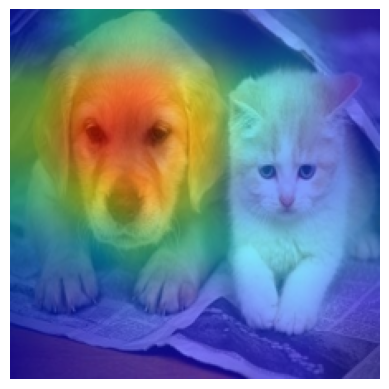

In [ ]:
# gradcam with test image
test_img = fetch_img('https://i.pinimg.com/736x/c1/7a/a2/c17aa2055d3c4e3007d0e4b432dfd3a4.jpg')
gradcam(test_img, model, input_dim, last_conv_layer_name)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Predicted: [('n02099601', 'golden_retriever', 0.50699985)]


(array([[0.18698356, 0.14807266, 0.15590237, 0.2803666 , 0.3243581 ,
         0.3155625 , 0.24479045],
        [0.04800624, 0.        , 0.        , 0.11892031, 0.3429722 ,
         0.51164544, 0.339067  ],
        [0.        , 0.        , 0.        , 0.        , 0.6356273 ,
         0.79923   , 0.42108124],
        [0.09502537, 0.        , 0.        , 0.13219368, 0.7658658 ,
         1.        , 0.56694466],
        [0.18025535, 0.14885345, 0.14019433, 0.26485717, 0.40891975,
         0.5458007 , 0.4175331 ],
        [0.20556916, 0.23828654, 0.2088535 , 0.18671176, 0.23395525,
         0.32072714, 0.2606561 ],
        [0.22004436, 0.22698165, 0.19177833, 0.11022099, 0.09262454,
         0.16167417, 0.14130172]], dtype=float32),
 <PIL.Image.Image image mode=RGB size=224x224>)

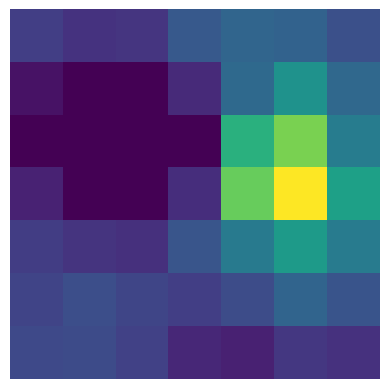

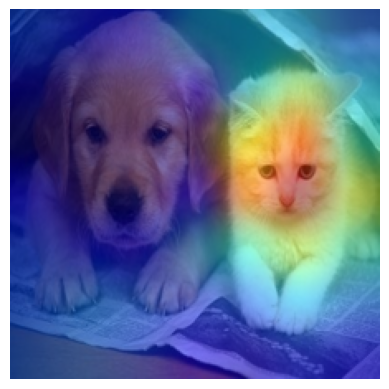

In [ ]:
# gradcam with test image for the prediction 281 - tabby cat
gradcam(test_img, model, input_dim, last_conv_layer_name, 281)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted: [('n04350905', 'suit', 0.19539803)]


(array([[0.29231632, 0.32115704, 0.43963346, 0.53784096, 0.41760182,
         0.3083314 , 0.31044993],
        [0.29083538, 0.35803184, 0.58311135, 0.80636746, 0.6262281 ,
         0.33116055, 0.2988387 ],
        [0.367842  , 0.5491656 , 0.7013693 , 1.        , 0.8082129 ,
         0.51351285, 0.31802878],
        [0.49958324, 0.9051343 , 0.9320451 , 0.8344898 , 0.7574823 ,
         0.49788964, 0.38018093],
        [0.612602  , 0.87318903, 0.8060996 , 0.6086811 , 0.6202073 ,
         0.58132654, 0.40197664],
        [0.52623844, 0.7690232 , 0.6578212 , 0.57134306, 0.6102245 ,
         0.39950064, 0.2874291 ],
        [0.5580267 , 0.76048034, 0.73844045, 0.7364698 , 0.8145043 ,
         0.506737  , 0.43754187]], dtype=float32),
 <PIL.Image.Image image mode=RGB size=224x224>)

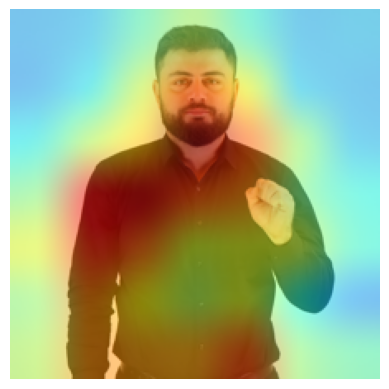

In [ ]:
gradcam(img, model, input_dim, last_conv_layer_name)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Predicted: [('n04350905', 'suit', 0.19539803)]


(array([[0.29231632, 0.32115704, 0.43963346, 0.53784096, 0.41760182,
         0.3083314 , 0.31044993],
        [0.29083538, 0.35803184, 0.58311135, 0.80636746, 0.6262281 ,
         0.33116055, 0.2988387 ],
        [0.367842  , 0.5491656 , 0.7013693 , 1.        , 0.8082129 ,
         0.51351285, 0.31802878],
        [0.49958324, 0.9051343 , 0.9320451 , 0.8344898 , 0.7574823 ,
         0.49788964, 0.38018093],
        [0.612602  , 0.87318903, 0.8060996 , 0.6086811 , 0.6202073 ,
         0.58132654, 0.40197664],
        [0.52623844, 0.7690232 , 0.6578212 , 0.57134306, 0.6102245 ,
         0.39950064, 0.2874291 ],
        [0.5580267 , 0.76048034, 0.73844045, 0.7364698 , 0.8145043 ,
         0.506737  , 0.43754187]], dtype=float32),
 <PIL.Image.Image image mode=RGB size=224x224>)

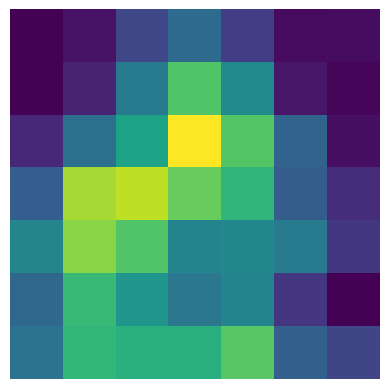

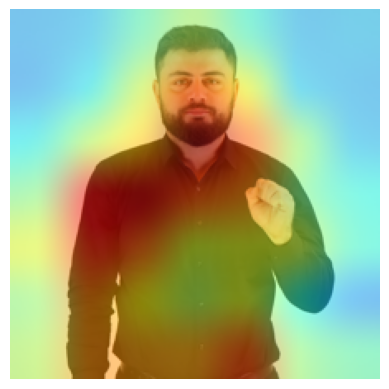

In [ ]:
# predicting for
gradcam(img, model, input_dim, last_conv_layer_name, )

In [ ]:
def plot_gradcams(img_ids, imgs, model, input_dim, last_conv_layer_name, verbose=False):
    superimposed_imgs = []

    for img_id in img_ids:
        img = imgs[img_id]
        _, superimposed = gradcam(img, model, input_dim, last_conv_layer_name, verbose=verbose)
        superimposed_imgs.append(superimposed)

    plt.figure(figsize=(15, 5))

    plt.subplot(1, len(superimposed_imgs) + 1, 1)  # Extra space for the title
    plt.text(0.5, 0.5, model.name, fontsize=16, ha='center')  # Centered title
    plt.axis('off')

    for i, heatmap in enumerate(superimposed_imgs):
        plt.subplot(1, len(superimposed_imgs) + 1, i + 2)
        plt.imshow(heatmap)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

574710816/574710816 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step
vgg19 loaded
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


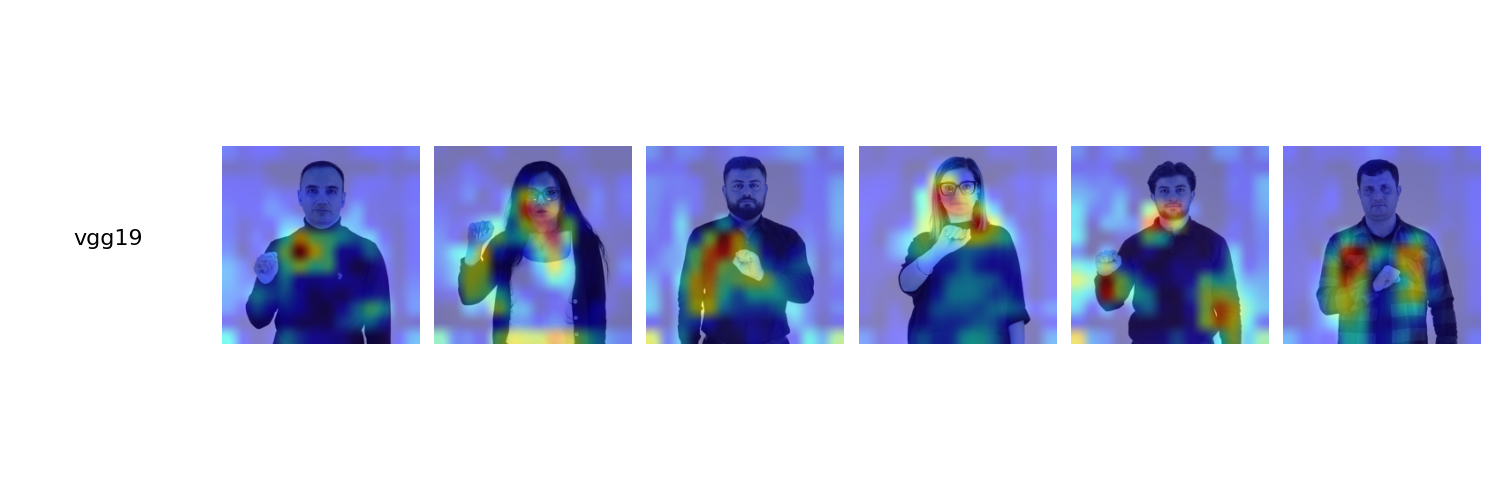

102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
resnet50 loaded
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


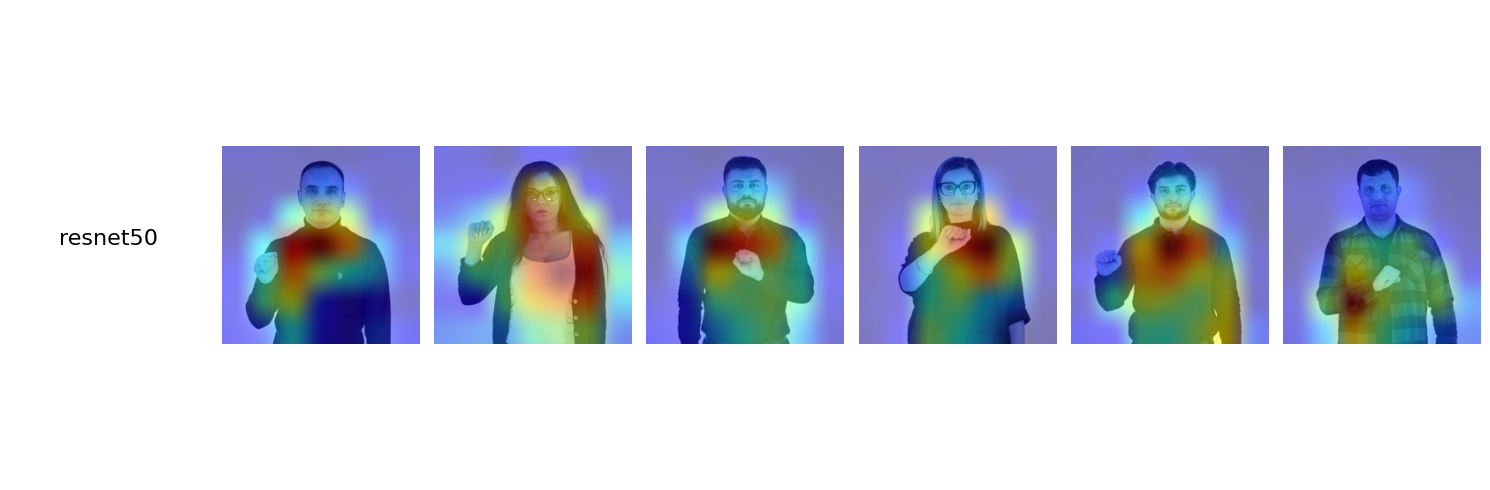

96112376/96112376 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
inception_v3 loaded
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


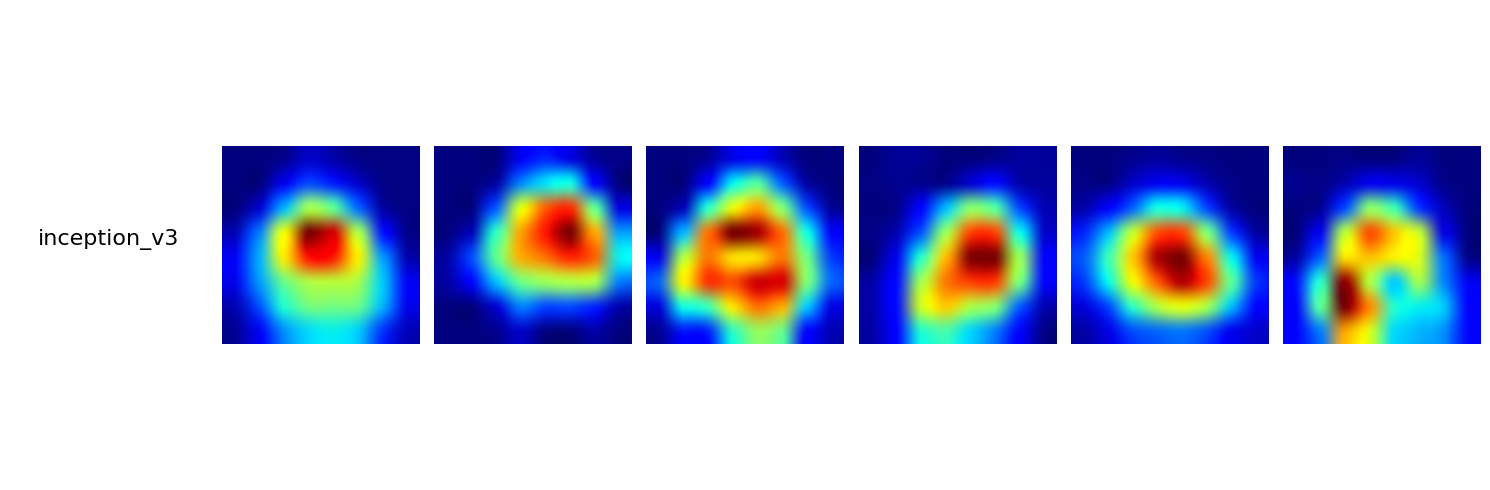

efficientnetb0 loaded
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


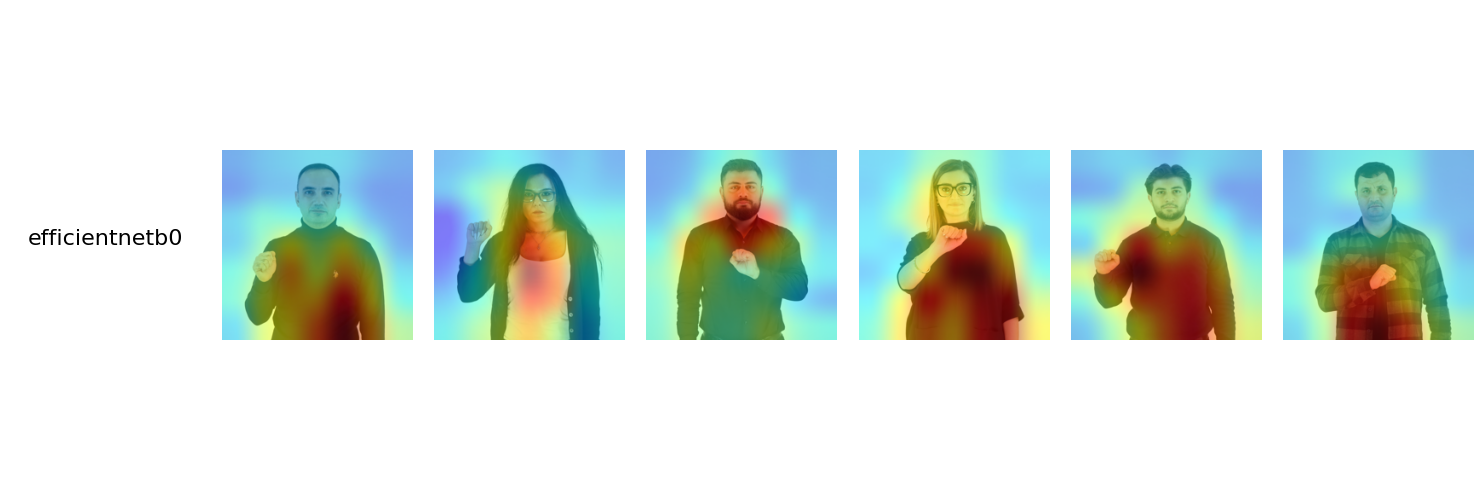

32148312/32148312 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
efficientnetb1 loaded
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


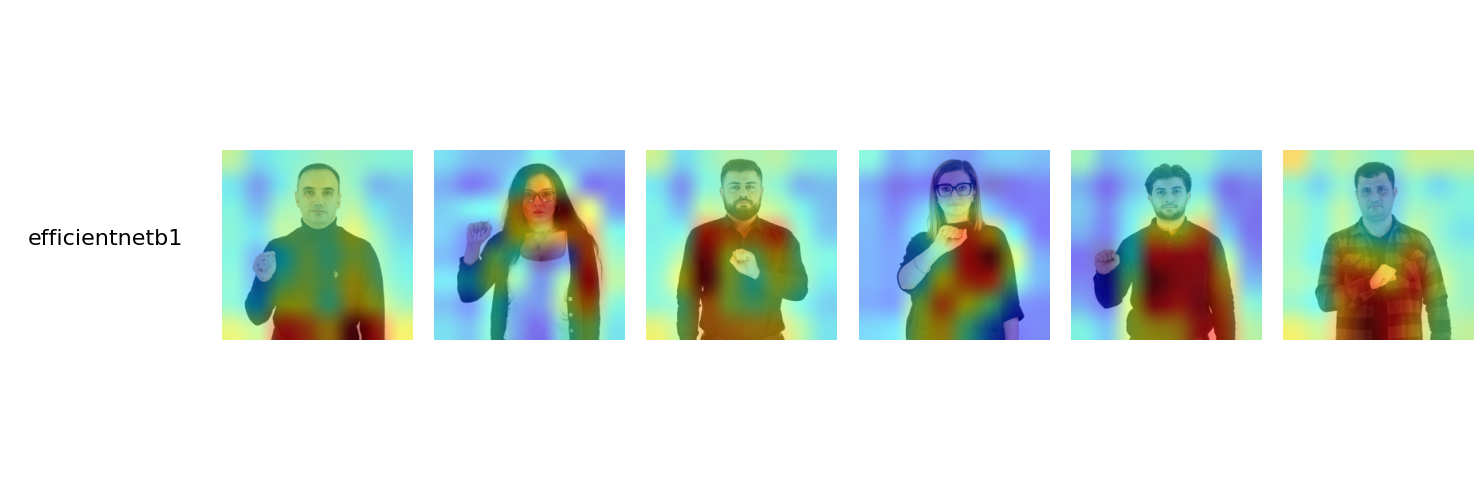

174460376/174460376 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
efficientnetb6 loaded
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


In [ ]:
# Plotting superimposed heatmaps for all models for selected images
# Inception has issue
img_ids = [0, 2, 10, 12, 17, 31]
for model_name in available_models:
  model, last_conv_layer_name, input_dim, preprocess_input, decode_predictions = load_model(model_name, include_top, debug)
  plot_gradcams(img_ids, imgs, model, input_dim, last_conv_layer_name)

In [ ]:
# !pip install mediapipe

In [ ]:
# from hand_extraction import *
# hand_imgs = detect_and_crop_hands(imgs, (600, 600))
# len(hand_imgs)

In [ ]:
# for model_name in available_models:
#   model, last_conv_layer_name, input_dim, preprocess_input, decode_predictions = load_model(model_name, include_top, debug)
#   plot_gradcams([0, 1, 2, 3], hand_imgs, model, input_dim, last_conv_layer_name, verbose=True)